In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
ufo = pd.read_csv('complete.csv', on_bad_lines='skip')

/tmp/ipykernel_4882/3549136725.py:1: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  ufo = pd.read_csv('complete.csv', on_bad_lines='skip')


In [4]:
ufo.head(5)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [5]:
ufo.info

<bound method DataFrame.info of                datetime                  city state country     shape  \
0      10/10/1949 20:30            san marcos    tx      us  cylinder   
1      10/10/1949 21:00          lackland afb    tx     NaN     light   
2      10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3      10/10/1956 21:00                  edna    tx      us    circle   
4      10/10/1960 20:00               kaneohe    hi      us     light   
...                 ...                   ...   ...     ...       ...   
88674    9/9/2013 22:00                  napa    ca      us     other   
88675    9/9/2013 22:20                vienna    va      us    circle   
88676    9/9/2013 23:00                edmond    ok      us     cigar   
88677    9/9/2013 23:00                 starr    sc      us   diamond   
88678    9/9/2013 23:30        ft. lauderdale    fl      us      oval   

      duration (seconds) duration (hours/min)  \
0                   2700           45 minu

In [6]:
ufo.shape

(88679, 11)

In [7]:
ufo.isnull().sum()

datetime                    0
city                        0
state                    7409
country                 12365
shape                    2922
duration (seconds)          2
duration (hours/min)     3019
comments                   35
date posted                 0
latitude                    0
longitude                   0
dtype: int64

In [8]:
#Drop Nan values
ufo.dropna(inplace=True)

In [9]:
ufo = ufo.rename(columns = {'duration (seconds)': 'duration_second',
            'duration (hours/min)': 'duration_min_hours',
            'date posted': 'date_posted'})

In [10]:
# Convert the 'datetime' column to datetime format
ufo['datetime'] = pd.to_datetime(ufo['datetime'], errors='coerce')
ufo['date_posted'] = pd.to_datetime(ufo['date_posted'], errors='coerce')

In [11]:
#Check Nan values
ufo.isnull().sum()

datetime              546
city                    0
state                   0
country                 0
shape                   0
duration_second         0
duration_min_hours      0
comments                0
date_posted             0
latitude                0
longitude               0
dtype: int64

In [12]:
#Drop Nan values
ufo.dropna(inplace=True)

In [13]:
# Extract components from columns and create new columns
column = ['datetime', 'date_posted']

for col in column:
  ufo[col] = ufo[col].apply(lambda x: x.replace(hour=0) if pd.notnull(x) and x.hour == 24 else x)

ufo['datetime_month'] = ufo['datetime'].dt.month.astype(int)
ufo['datetime_day'] = ufo['datetime'].dt.day.astype(int)
ufo['datetime_year'] = ufo['datetime'].dt.year.astype(int)
ufo['datetime_hour'] = ufo['datetime'].dt.hour.astype(int)
ufo['datetime_min'] = ufo['datetime'].dt.minute.astype(int)

ufo['date_posted_month'] = ufo['date_posted'].dt.month
ufo['date_posted_day'] = ufo['date_posted'].dt.day
ufo['date_posted_year'] = ufo['date_posted'].dt.year
ufo['date_posted_hour'] = ufo['date_posted'].dt.hour
ufo['date_posted_min'] = ufo['date_posted'].dt.minute

# Drop the original 'datetime' and 'date_posted' columns
ufo = ufo.drop(columns=['date_posted', 'datetime'], axis=1)

In [14]:
def extract_minutes(comment):
    if pd.isnull(comment):
        return None

    numbers = re.findall(r'\d+', comment)

    if len(numbers) == 1:
        return int(numbers[0])
    elif len(numbers) == 2:
        return (int(numbers[0]) + int(numbers[1])) / 2
    else:
        return None

ufo['duration_minutes'] = ufo['duration_min_hours'].apply(extract_minutes)
print(ufo[['duration_min_hours', 'duration_minutes']])
#Drop the original column
ufo.drop(columns='duration_min_hours', inplace=True)

      duration_min_hours  duration_minutes
0             45 minutes              45.0
3               1/2 hour               1.5
4             15 minutes              15.0
5              5 minutes               5.0
7             20 minutes              20.0
...                  ...               ...
88674               hour               NaN
88675          5 seconds               5.0
88676         17 minutes              17.0
88677           2 nights               2.0
88678     still occuring               NaN

[68982 rows x 2 columns]


In [15]:
#Drop Nan
ufo.dropna(inplace=True)

In [16]:
shape = {
    'changing': ['changed', 'changing'],
    'chevron': ['chevron', 'crescent'],
    'cylinder': ['cigar', 'cylinder'],
    'round': ['circle', 'disk', 'egg', 'hexagon', 'oval', 'round', 'sphere'],
    'square': ['cross', 'diamond', 'rectangle'],
    'triangle': ['cone', 'delta', 'pyramid', 'triangle'],
    'light': ['fireball', 'flare', 'flash', 'light'],
    'otherSeen': ['other'],
    'otherSeen2': ['dome', 'formation', 'teardrop', 'unknown']
}

for ufo_shape, ali in shape.items():
    ufo.loc[ufo['shape'].isin(ali), 'ufo_shape'] = ufo_shape

#Drop original column
ufo.drop(columns='shape', inplace=True)

In [17]:
#Check DataSet
ufo.head()

,city,state,country,duration_second,comments,latitude,longitude,datetime_month,datetime_day,datetime_year,datetime_hour,datetime_min,date_posted_month,date_posted_day,date_posted_year,date_posted_hour,date_posted_min,duration_minutes,ufo_shape
0,san marcos,tx,us,2700,This event took place in early fall around 194...,29.8830556,-97.941111,10,10,1949,20,30,4,27,2004,0,0,45.0,cylinder
3,edna,tx,us,20,My older brother and twin sister were leaving ...,28.9783333,-96.645833,10,10,1956,21,0,1,17,2004,0,0,1.5,round
4,kaneohe,hi,us,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.4180556,-157.803611,10,10,1960,20,0,1,22,2004,0,0,15.0,light
5,bristol,tn,us,300,My father is now 89 my brother 52 the girl wit...,36.5950000,-82.188889,10,10,1961,19,0,4,27,2007,0,0,5.0,round
7,norwalk,ct,us,1200,A bright orange color changing to reddish colo...,41.1175000,-73.408333,10,10,1965,23,45,10,2,1999,0,0,20.0,round


In [18]:
#Convert type columns from object to float
ufo['latitude'] = ufo['latitude'].astype('float64')
ufo['duration_second'] = ufo['duration_second'].astype('float64')

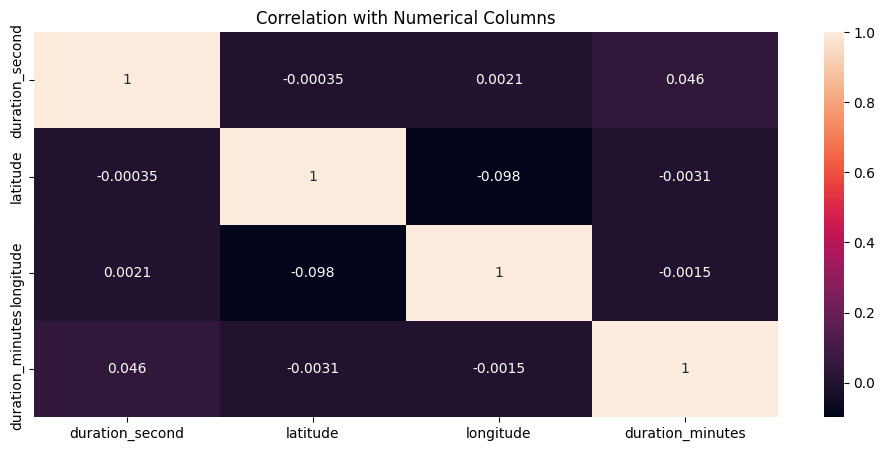

In [19]:
# Corelation columns
plt.figure(figsize=(12, 5))
sns.heatmap(ufo.select_dtypes(include=['int64', 'float64']).corr(), annot=True)
plt.title('Correlation with Numerical Columns')
plt.show()

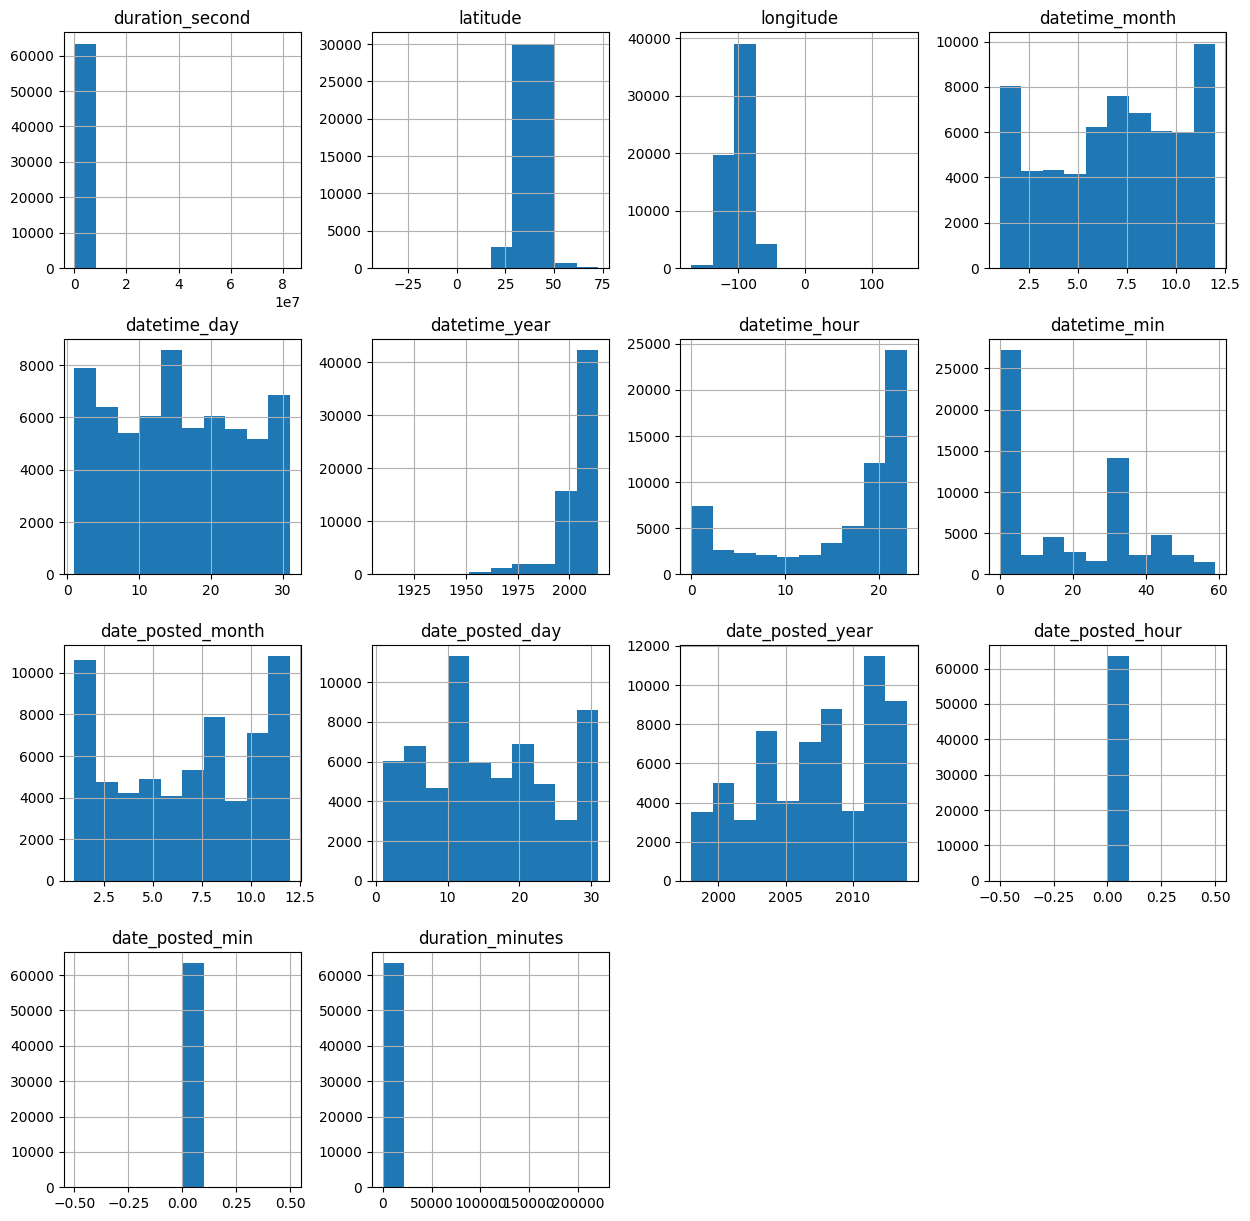

In [20]:
#Plot histograms of columns
ufo.hist(figsize=(15, 15))
plt.show()

In [21]:
#Remove outliers of 2 columns
print(f'Numbers rows before deleting outliers [duration_second]: {len(ufo)}')
ufo = ufo[ufo['duration_second'] < 50000000.0]
print(f'Numbers rows after deleting outliers [duration_second]: {len(ufo)}')


print(f'Numbers rows before deleting outliers [duration_minutes]: {len(ufo)}')
ufo = ufo[ufo['duration_minutes'] < 200000]
print(f'Numbers rows after deleting outliers [duration_minutes]: {len(ufo)}')

Numbers rows before deleting outliers [duration_second]: 63448
Numbers rows after deleting outliers [duration_second]: 63444
Numbers rows before deleting outliers [duration_minutes]: 63444
Numbers rows after deleting outliers [duration_minutes]: 63442


C:\Users\sethp\AppData\Local\Temp\ipykernel_8704\3199981475.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=ufo['state'].str.upper(), y=ufo['datetime_year'], data=ufo, ci=None, hue='country')


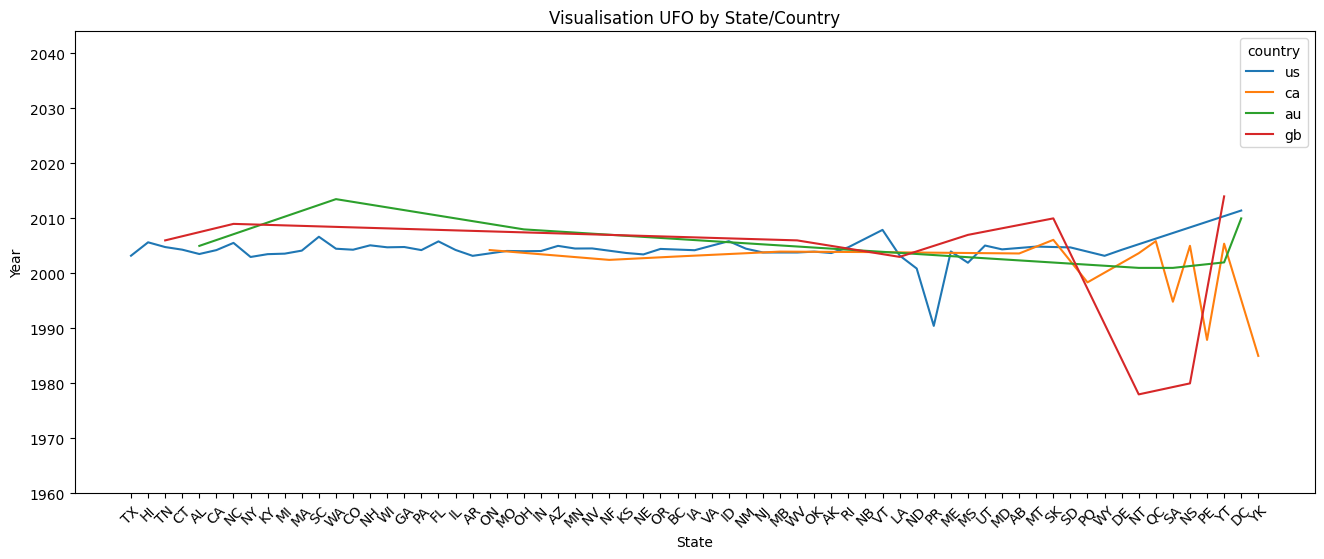

In [22]:
#In which countries and states are the most sightings
plt.figure(figsize=(16,6))
sns.lineplot(x=ufo['state'].str.upper(), y=ufo['datetime_year'], data=ufo, ci=None, hue='country')
plt.title('Visualisation UFO by State/Country')
plt.xlabel('State')
plt.ylabel('Year')
plt.xticks(rotation=45)
plt.ylim(1960, ufo['datetime_year'].max()+30)
plt.show()

In [23]:
ufo['ufo_shape'].value_counts()

ufo_shape
light         19687
round         18130
otherSeen2     7097
triangle       6815
otherSeen      4458
cylinder       2667
square         2197
changing       1566
chevron         825
Name: count, dtype: int64

C:\Users\sethp\AppData\Local\Temp\ipykernel_8704\2089054171.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ufo_shape', data=ufo, palette='viridis')


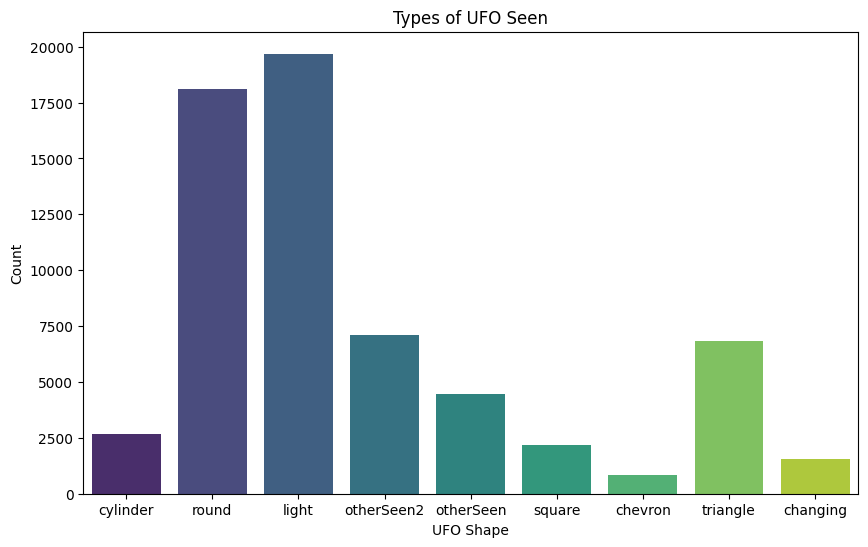

In [24]:
#Visualizing the most frequently observed UFO shape
plt.figure(figsize=(10, 6))
sns.countplot(x='ufo_shape', data=ufo, palette='viridis')
plt.xlabel('UFO Shape')
plt.ylabel('Count')
plt.title('Types of UFO Seen')
plt.show()

In [25]:
#Create a new column by grouped visualization of UFO sightings during the day or night

ufo['time_of_day'] = ''
ufo.loc[(ufo['datetime_hour'] >= 6) & (ufo['datetime_hour'] <= 18), 'time_of_day'] = 'Day'
ufo.loc[(ufo['datetime_hour'] > 18) | (ufo['datetime_hour'] < 6), 'time_of_day'] = 'Night'
obsev_by_time_of_day = ufo['time_of_day'].value_counts()

ufo['datetime_season'] = ''
ufo.loc[(ufo['datetime_month'] >= 3) & (ufo['datetime_month'] <= 5), 'datetime_season'] = 'spring'
ufo.loc[(ufo['datetime_month'] >= 6) & (ufo['datetime_month'] <= 8), 'datetime_season'] = 'summer'
ufo.loc[(ufo['datetime_month'] >= 9) & (ufo['datetime_month'] <= 11), 'datetime_season'] = 'autumn'
ufo.loc[(ufo['datetime_month'] == 12) | (ufo['datetime_month'] == 1) | (ufo['datetime_month'] == 2), 'datetime_season'] = 'winter'
obsev_by_time_of_season = ufo['datetime_season'].value_counts()

print(obsev_by_time_of_day)
print(obsev_by_time_of_season)

time_of_day
Night    47736
Day      15706
Name: count, dtype: int64
datetime_season
summer    20666
autumn    17513
spring    12759
winter    12504
Name: count, dtype: int64


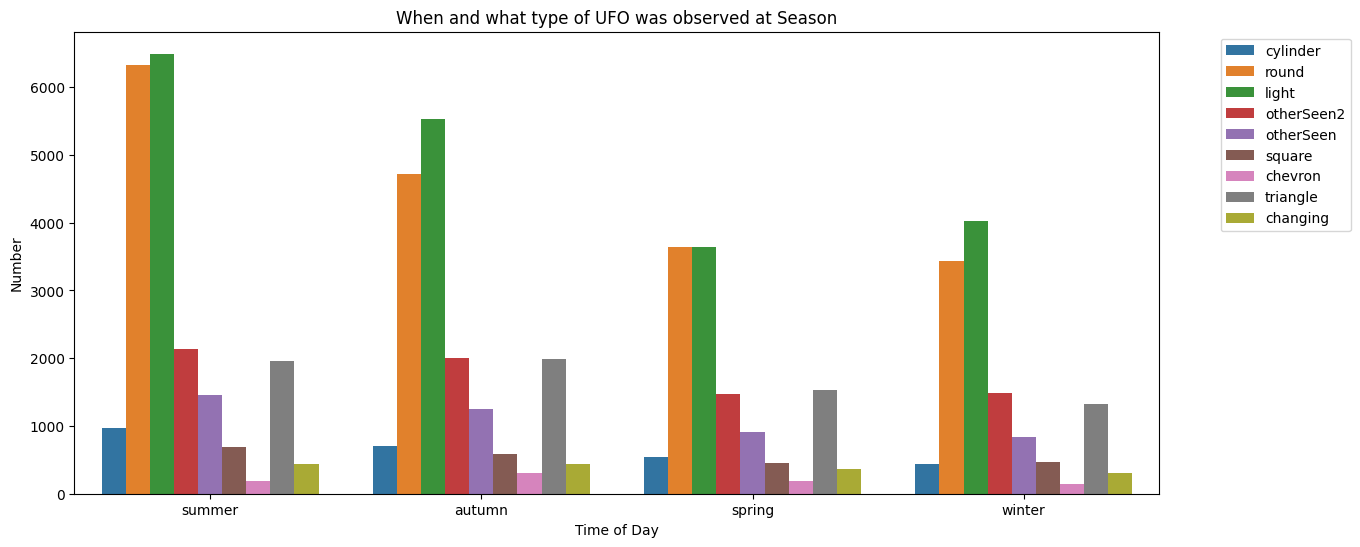

In [26]:
plt.figure(figsize=(14, 6))
sns.countplot(data=ufo, x='datetime_season', hue='ufo_shape', order=ufo['datetime_season'].value_counts().index)
sns.color_palette("magma")
plt.title('When and what type of UFO was observed at Season')
plt.xlabel('Time of Day')
plt.ylabel('Number')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

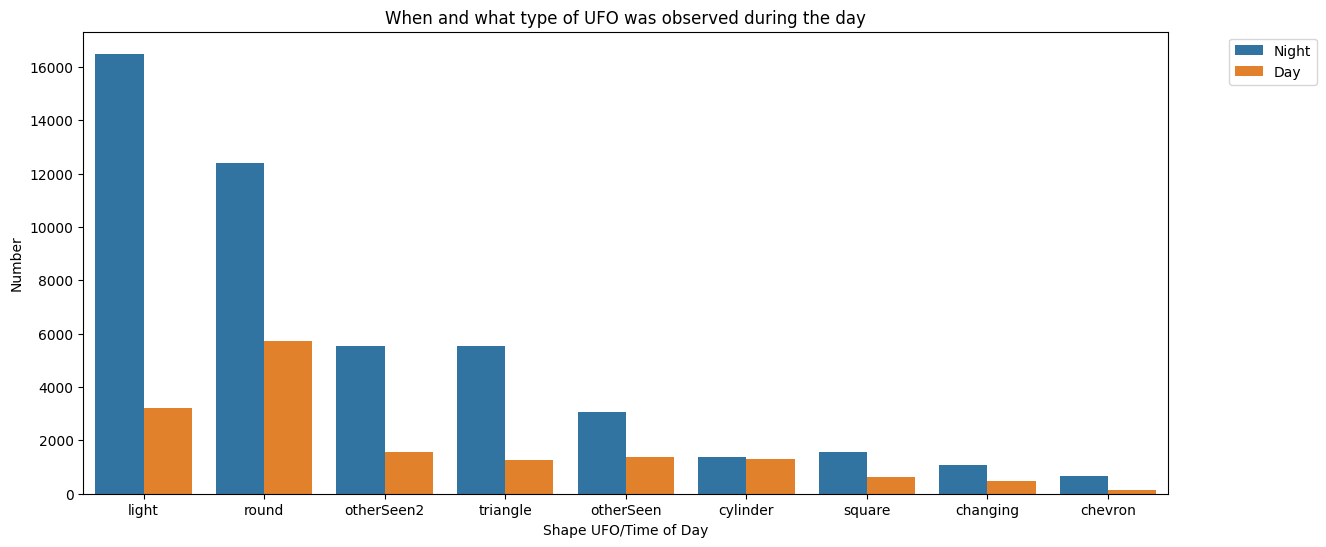

In [27]:
plt.figure(figsize=(14, 6))
sns.countplot(data=ufo, x='ufo_shape', hue='time_of_day', order=ufo['ufo_shape'].value_counts().index)
sns.color_palette("rocket")
plt.title('When and what type of UFO was observed during the day')
plt.xlabel('Shape UFO/Time of Day')
plt.ylabel('Number')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [28]:
descriptions = ufo['comments'].dropna()  # Drop any NaN values if present

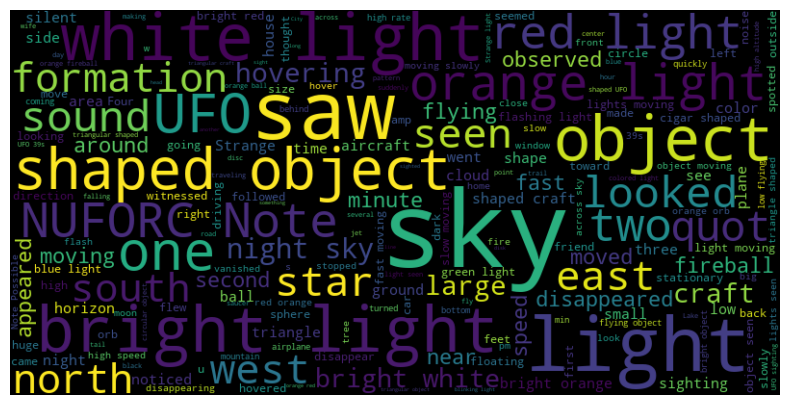

In [29]:
# Combine all descriptions into a single string
text = ' '.join(descriptions)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [30]:
locations = ufo[['latitude', 'longitude']].dropna()

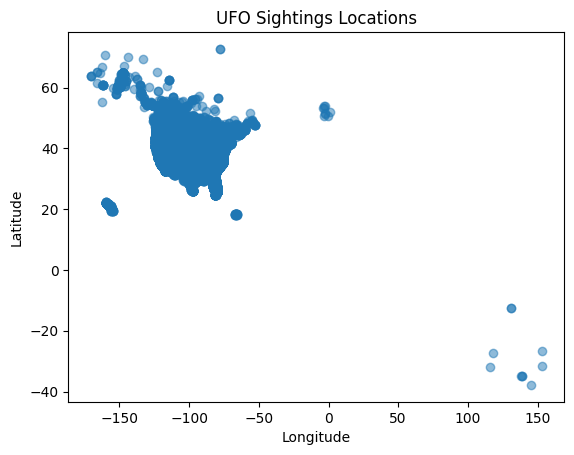

In [31]:
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(locations['longitude'], locations['latitude'], alpha=0.5)
plt.title('UFO Sightings Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


C:\Users\sethp\AppData\Local\Temp\ipykernel_8704\2465641493.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=ufo['country'].str.upper(), y=ufo['duration_second'], ci=None, palette='cubehelix', hue=ufo['ufo_shape'])


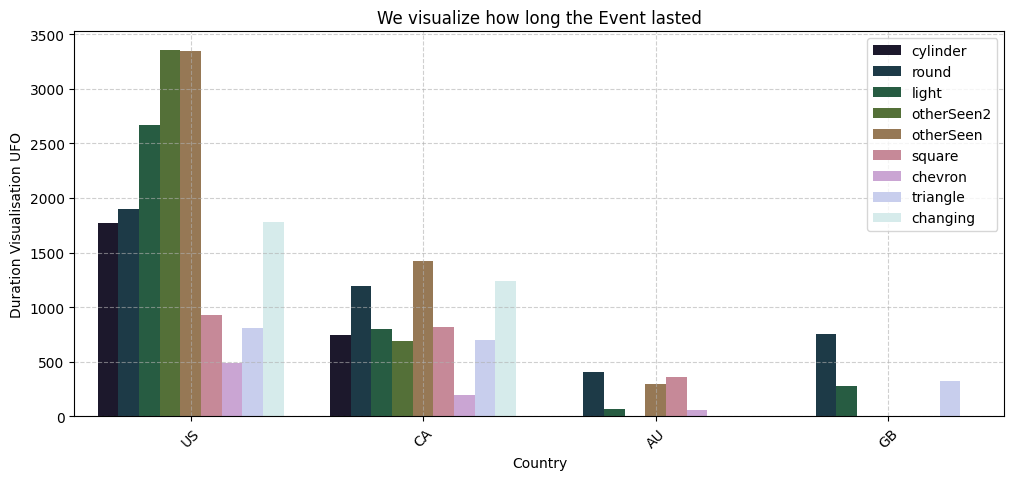

In [32]:
#Visualized duration of UFO sightings in the sky by Country
plt.figure(figsize=(12, 5))
sns.barplot(x=ufo['country'].str.upper(), y=ufo['duration_second'], ci=None, palette='cubehelix', hue=ufo['ufo_shape'])

plt.title('We visualize how long the Event lasted')
plt.xlabel('Country')
plt.ylabel('Duration Visualisation UFO')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [33]:
ufo_cop = ufo.copy()
object_columns = list(ufo_cop.select_dtypes(include='object'))

le = LabelEncoder()

for col in object_columns:
  ufo_cop[col] = le.fit_transform(ufo_cop[col])

In [34]:
# Create target variable and feature Matrix X

X = ufo_cop.drop(columns=['latitude', 'longitude'], axis=1)
y_latitude = ufo_cop['latitude']
y_longitude = ufo_cop['longitude']

In [35]:
X_train, X_test, y_train_latitude, y_test_latitude, y_train_longitude, y_test_longitude = train_test_split(X, y_latitude, y_longitude, test_size=0.2, random_state=1)
mms = MinMaxScaler()
X = mms.fit_transform(X)

In [53]:

# Initialize Random Forest Regressor models

"""param_grid = {
    'max_features' : ["auto", "sqrt", "log2"],
    'min_samples_split' : np.linspace(0.1, 1.0, 5),
     'max_depth' : [x for x in range(1,12)],
    'n_estimators' : [10, 50, 100]
    }

cv_latitude = GridSearchCV(estimator= RandomForestRegressor(), param_grid= param_grid, cv= 3, n_jobs= -1)
cv_latitude.fit(X_train, y_train_latitude)
best_param_latitude = cv_latitude.best_params_

cv_longitude = GridSearchCV(estimator= RandomForestRegressor(), param_grid= param_grid, cv= 3, n_jobs= -1)
cv_longitude.fit(X_train, y_train_longitude)
best_param_longitude = cv_longitude.best_params_"""

 #Train the models
rf_latitude = RandomForestRegressor()
rf_latitude.fit(X_train, y_train_latitude)

rf_longitude = RandomForestRegressor()
rf_longitude.fit(X_train, y_train_longitude)

# Make predictions
y_pred_latitude_rf = rf_latitude.predict(X_test)
y_pred_longitude_rf = rf_longitude.predict(X_test)


# Evaluate the performance
mae_latitude_rf = mean_absolute_error(y_test_latitude, y_pred_latitude_rf)
mse_latitude_rf = mean_squared_error(y_test_latitude, y_pred_latitude_rf)
r2_latitude_rf = r2_score(y_test_latitude, y_pred_latitude_rf)

mae_longitude_rf = mean_absolute_error(y_test_longitude, y_pred_longitude_rf)
mse_longitude_rf = mean_squared_error(y_test_longitude, y_pred_longitude_rf)
r2_longitude_rf = r2_score(y_test_longitude, y_pred_longitude_rf)


# Print the evaluation metrics
print(f"mean_absolute_error latitude: {mae_latitude_rf}")
print(f"mean_squared_error latitude: {mse_latitude_rf}")
print(f"r2_score latitude: {r2_latitude_rf}\n")
print(f"mean_absolute_error longitude: {mae_longitude_rf}")
print(f"mean_squared_error longitude: {mse_longitude_rf}")
print(f"r2_score longitude: {r2_longitude_rf}")

mean_absolute_error latitude: 0.4750989766004175
mean_squared_error latitude: 0.6867723516949056
r2_score latitude: 0.9795990493503235

mean_absolute_error longitude: 0.72076985444158
mean_squared_error longitude: 3.7232245485393025
r2_score longitude: 0.9888612880379073


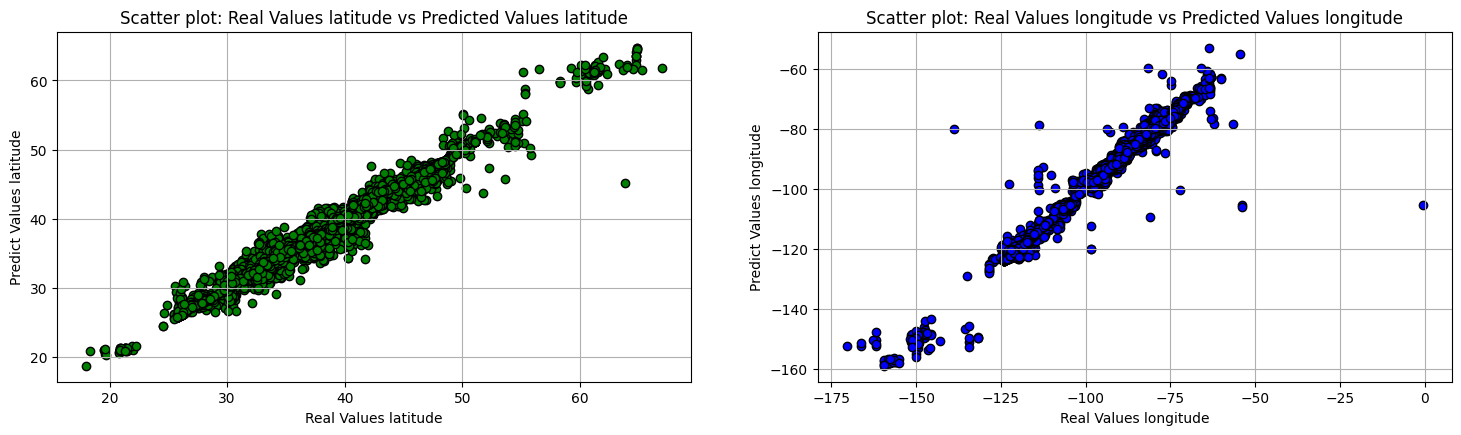

In [37]:
# Visualised Real Values, Predicted Values and Errors Distribution
plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
plt.scatter(y_test_latitude, y_pred_latitude_rf, color= 'green', edgecolors='black')
plt.xlabel('Real Values latitude')
plt.ylabel('Predict Values latitude')
plt.title('Scatter plot: Real Values latitude vs Predicted Values latitude')
plt.grid()

plt.subplot(2, 2, 2)
plt.scatter(y_test_longitude, y_pred_longitude_rf, color= 'blue', edgecolors='black')
plt.xlabel('Real Values longitude')
plt.ylabel('Predict Values longitude')
plt.title('Scatter plot: Real Values longitude vs Predicted Values longitude')
plt.grid()

In [38]:
locations = ufo[['latitude', 'longitude']].dropna()

In [55]:
df_pred_lat = pd.DataFrame({'predict_latitude_reg': y_pred_latitude_rf})
df_pred_lon = pd.DataFrame({'predict_longitude_reg': y_pred_longitude_rf})
ufo_cop['predict_latitude_ufo'] = df_pred_lat['predict_latitude_reg']
ufo_cop['predict_longitude_ufo'] = df_pred_lon['predict_longitude_reg']

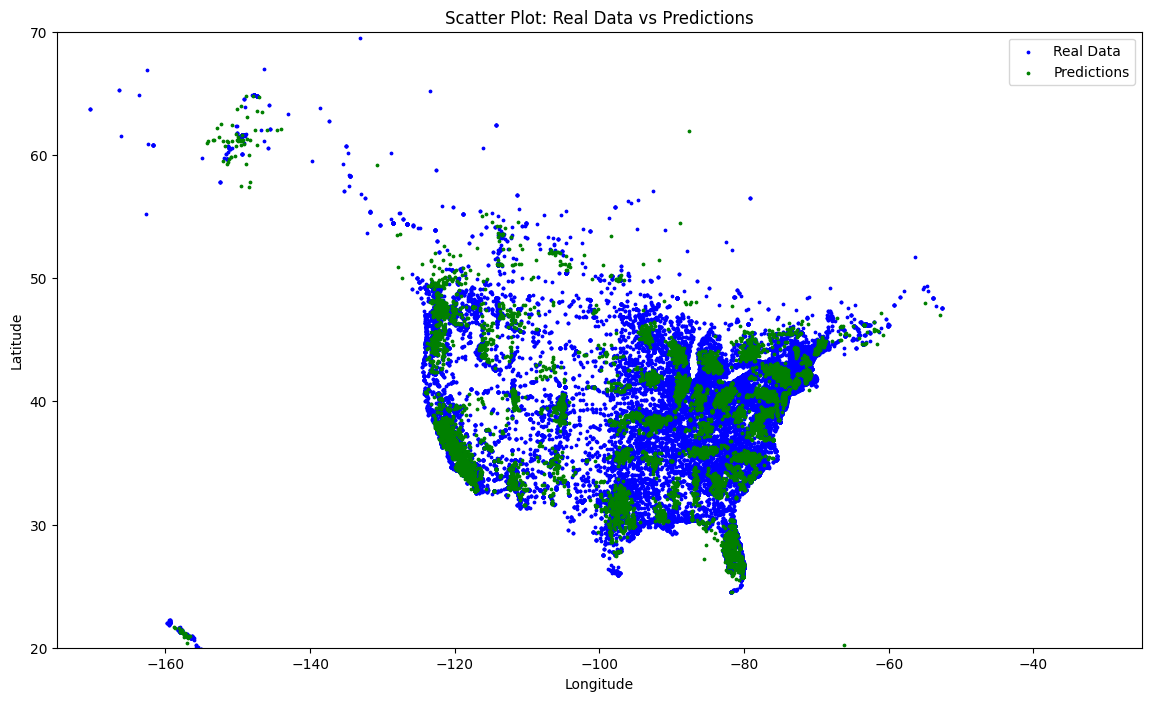

In [56]:
# Plot: Visualised Real Data and Predict Data
plt.figure(figsize=(14, 8))
plt.scatter(ufo_cop['longitude'], ufo_cop['latitude'], color='blue', label='Real Data', s=3)
mask = ~ufo_cop['predict_latitude_ufo'].isnull() & ~ufo_cop['predict_longitude_ufo'].isnull()
plt.scatter(ufo_cop.loc[mask, 'predict_longitude_ufo'], ufo_cop.loc[mask, 'predict_latitude_ufo'], color='green', label='Predictions', s=3)
plt.title('Scatter Plot: Real Data vs Predictions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-175, -25)
plt.ylim(20, 70)
plt.legend()
plt.show()
